<a href="https://colab.research.google.com/github/alejandroariaszuluaga/analisis_senales/blob/main/tarea9_AISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tarea 9 AISS**

## **Punto 1**

Clustering para compresión de imagen. La falta de la solución en alguno de los enunciados de esta tarea implicará una nota de 0.0 en este ejercicio. Considere la imagen a color imagen3.png. El objetivo de este ejercicio es poder comprimir la imagen de tal manera que pueda ser representada con tan solo 16 niveles de color utilizando algún algoritmo de clustering. Si lo desea, puede utilizar la rutina clusteringImageTarea9.m que tiene varios de los pasos listos para resolver este problema.

In [238]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from google.colab import files
from scipy.stats import multivariate_normal
import cv2
import math
import random
from tqdm import tqdm
import time

Una forma de cargar los archivos es usando `files.upload()`
Aquí se debe subir el archivo llamado `imagen3.png`

In [113]:
from google.colab import files
# files.upload()

Otra forma, la cual se puede usar si se tiene el archivo en Google drive en el directorio `/content/gdrive/MyDrive/ColabNotebooks/AISS/` es importándolos desde allí directamente.

In [114]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##**1.A**
Lea la imagen imagen3.png en RGB. Esta imagen corresponde a un arreglo de $600 \times 800 \times 3$. Asuma que cada pixel es una observación de 3 dimensiones, y genere una matrix $X$ de tamaño $480000 \times 3$, cuyas filas están asociadas a cada pixel.

(480000, 3)

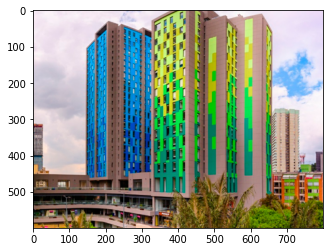

In [135]:
# Leer y organizar datos

# Read Images
img = mpimg.imread('/content/gdrive/MyDrive/Colab Notebooks/AISS/imagen3.png')
  
# Output Images
plt.imshow(img)

I = img/256 # Leer imagen
matriz_X = np.reshape(I,(I.shape[0]*I.shape[1],3)); # Vectorizar imagen
matriz_X.shape

In [275]:
test_width = 5
test_length = 5
num_interes = test_width*test_length*3 # Defino este valor para hacer pruebas con pocos datos
muestras = np.copy(matriz_X[:num_interes])

## **1.B**

Grafique los puntos 3D en X utilizando la función de Matlab plot3 o su equivalente en Python. Esta es una representación de la imagen en el espacio RGB.

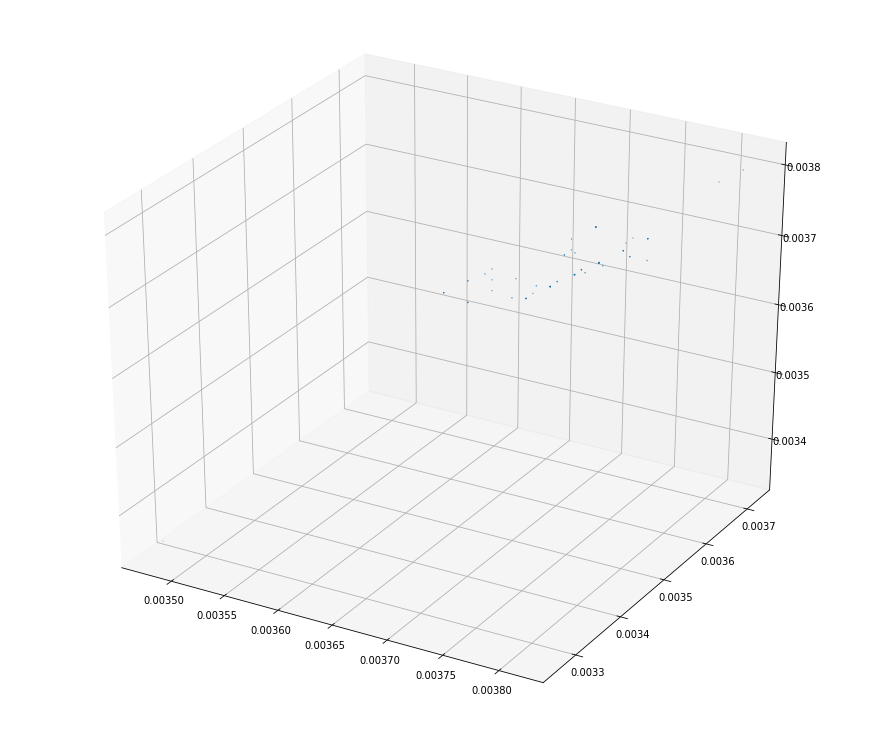

In [276]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter( muestras[:num_interes,0], muestras[:num_interes,1], muestras[:num_interes,2], s=0.18 )
plt.show()

## **1.C**

Utilizando el algoritmo EM para combinación de Gaussianas ya implementado en tareas anteriores (no puede utilizar funciones predefinidas para esto), encuentre K = 16 gaussianas para representar los datos en X y la pertenencia de cada uno de los 480000 datos a estas distribuciones. Grafique de nuevo
los puntos 3D en X como en el enunciado en a), pero ahora marque claramente la posición de las medias de las 16 Gaussianas, y pinte los datos con algún código de colores que permita identificar la pertenencia de los datos a las distribuciones Gaussianas.

### Algoritmo EM

In [277]:
def cov_gauss(XYZ,mu):
  suma = np.zeros([3,3])
  for i in range(len(XYZ)):
    t = XYZ[i]-mu
    # prod = np.array([[t[0]**2,t[0]*t[1],t[0]*t[2]], [t[1]*t[0],t[1]**2,t[1]*t[2]], [t[2]*t[0],t[2]*t[1],t[2]**2]])
    prod = np.outer(t,t)
    suma += prod
  return (1/len(XYZ))*suma


In [278]:
mu_x = sum(muestras[:,0])/len(muestras)
mu_y = sum(muestras[:,1])/len(muestras)
mu_z = sum(muestras[:,2])/len(muestras)

mu_xyz = np.array([mu_x,mu_y,mu_z])
t0 = time.time()
cov_xyz = cov_gauss(muestras,mu_xyz)
print(f'Time spent {time.time()-t0}')

Time spent 0.0010833740234375


In [279]:
print(mu_xyz)
print(cov_xyz)

[0.0037259  0.00354126 0.00370772]
[[2.20000828e-09 2.23726191e-09 2.00030714e-09]
 [2.23726191e-09 2.96844261e-09 2.35749143e-09]
 [2.00030714e-09 2.35749143e-09 2.44947827e-09]]


In [280]:
def pdf_img(x,y,z,C_Z,mu_Z):
  z = np.array([x,y,z])
  p = ( 1 / ( 2 * np.pi * np.linalg.det(C_Z)**(1/2) ) ) * np.exp( - ( (np.transpose(z-mu_Z)).dot( np.linalg.inv(C_Z) ).dot( z-mu_Z ) ) / 2 )
  return p

In [281]:
x = np.linspace(0, 1, 40)
y = np.linspace(0, 1, 40)
z = np.linspace(0, 1, 40)

# Creación de una matriz que combina los valores del rango de X y Y
X,Y,Z = np.meshgrid(x, y, z)

# Los valores de la PDF se guardarán en la siguiente matriz
pdf_xyz = np.zeros( (len(X[0]), len(Y[0]), len(Z[0]) ) )

# Se evalúa la función definida anteriormente en cada uno de los puntos
for i in range(len(X[0])):
  for j in range(len(Y[0])):
    for k in range(len(Z[0])):
      pdf_xyz[i,j] = pdf_img(X[i,j,k],Y[i,j,k],Z[i,j,k],cov_xyz,mu_xyz)

### Superficies de Nivel (aún no se pueden graficar)

In [282]:
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.contour3D(X, Y, Z, 50, cmap='binary')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# ax.set_title('3D contour')
# plt.show()

# # Se grafican las curvas de nivel de la función definida
# plt.figure(figsize=(8,5))
# contours = plt.contour3D(X, Y, Z)
# plt.clabel(contours, inline=1, fontsize=10)
# # Se grafican los datos reales
# # plt.scatter(muestras[:,0], muestras[:,1])
# # Accesorios de la figura
# plt.title('Curvas de Nivel PDF vs. Datos')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

In [283]:
def func_obj(XYZ,alpha,mu,cov):
  s1 = 0
  for i in range(len(XYZ)):
    s2 = 0
    for j in range(len(alpha)):
      s2 += alpha[j]*pdf_img( XYZ[i][0],XYZ[i][1],XYZ[i][2],cov[j],mu[j] )
    s1 += np.log(s2)
  return s1

def func_gamma(XYZ,alpha,mu,cov,k):
  suma = 0
  for i in range(len(alpha)):
    suma += alpha[i]*pdf_img(XYZ[0],XYZ[1],XYZ[2],cov[i],mu[i])
  return alpha[k]*pdf_img(XYZ[0],XYZ[1],XYZ[2],cov[k],mu[k])/suma

def func_muk(XYZ,gamma,Nk,k):
  s = np.zeros(3)
  s = np.dot(gamma[k][:],XYZ[:])
  return s/Nk

def func_covk(XYZ,mu,gamma,Nk,k):
  suma = np.zeros([3,3])
  for i in range(len(XYZ)):
    t = XYZ[i]-mu[k]
    prod = np.outer(t,t)
    suma += prod*gamma[k][i]
  suma = suma/Nk
  return suma

In [284]:
def algoritmo_EM(XYZ,alpha_0,cov_0,mu_0):
  alpha = alpha_0
  cov = cov_0
  mu = mu_0
  
  alpha_acum = [alpha]
  cov_acum = [cov]
  mu_acum = [mu]

  func_max = func_obj(XYZ,alpha,mu,cov)
  cond1 = True
  cond2 = 0
  while cond1 and (cond2<7):
    print(f'Iteration {cond2} for EM algorithm')
    try:
      # E-Step
      gamma = np.zeros((len(alpha),len(XYZ)))
      for i in range(len(alpha)):
        for j in range(len(XYZ)):
          gamma[i][j] = func_gamma(XYZ[j],alpha,mu,cov,i)
      
      # M-Step
      # Estimado N_k
      N_k = np.zeros(len(alpha))
      for i in range(len(alpha)):
        N_k[i] = sum(gamma[i])

      # Estimado mu_k
      mu_k = np.zeros((len(alpha),3))
      for i in range(len(alpha)):
        mu_k[i] = func_muk(XYZ,gamma,N_k[i],i)
      
      # Estimando a_k
      a_k = N_k/len(XYZ)
      # Estimando C_k
      C_k = np.zeros((len(alpha),3,3))
      for i in range(len(alpha)):
        C_k[i] = func_covk(XYZ,mu,gamma,N_k[i],i)

      # Actualización de los parámetros
      alpha = a_k
      mu = mu_k
      cov = C_k

      alpha_acum.append(alpha)
      cov_acum.append(cov)
      mu_acum.append(mu)
      
      # Evalua la condicion para parar el ciclo
      f = func_obj(XYZ,alpha,mu,cov)
      cond1 = abs(func_max - f) > 0.001
      cond2 += 1
      func_max = f
    except Exception as e:
      print(cond2)
      print(f'Something happened because {e}, will break cycle')
  print(f'Did {cond2} iterations')
  return alpha_acum,cov_acum,mu_acum,gamma

In [285]:
# Condiciones iniciales
mu_0 = np.array([1,1,1])
C_Z0 = np.array([[1,0,0],[0,1,0],[0,0,1]])

alpha = np.random.random(16)
cov = np.array([C_Z0, 1.2*C_Z0, 1.5*C_Z0, 1.7*C_Z0, 2.1*C_Z0, 2.3*C_Z0, 1.4*C_Z0, 1.9*C_Z0, 2.0*C_Z0, 1.3*C_Z0, 2.4*C_Z0, 1.4*C_Z0, 1.5*C_Z0, 2.6*C_Z0, 2.1*C_Z0, 1.3*C_Z0])
mu = np.array([mu_0, 1.3*mu_0, mu_0, 1.2*mu_0, 2.1*mu_0, 1.4*mu_0, 1.5*mu_0, 1.7*mu_0, 1.9*mu_0, 2.1*mu_0, 2.3*mu_0, 1.3*mu_0, 2.4*mu_0, 1.3*mu_0, 2*mu_0, 2*mu_0])
t0 = time.time()
alpha_acum_16G, cov_acum_16G, mu_acum_16G,gamma = algoritmo_EM(muestras,alpha,cov,mu)
print(f'Time spent {time.time()-t0}')

Iteration 0 for EM algorithm
Iteration 1 for EM algorithm
Iteration 2 for EM algorithm
Iteration 3 for EM algorithm
Iteration 4 for EM algorithm
Iteration 5 for EM algorithm
Iteration 6 for EM algorithm
Did 7 iterations
Time spent 8.654948711395264


In [286]:
alpha_final = alpha_acum_16G[-1]
mu_final = mu_acum_16G[-1]

## **1.D**

Genere una nueva matriz de tamaño $480000\times3$ de la siguiente forma: tome cada fila de la matriz $X$ (es decir, cada pixel de la imagen), y reemplácela por la media $mu_k$ de la distribución Gaussiana a la que esa fila tiene mayor pertenencia. De esta manera, las $480000$ filas de esa matriz solamente van a tener $16$ tipos de vectores.

### **Pertenencia de Datos a Cada Gaussiana**

In [287]:
len(listas_pertenencias)

16

In [288]:
listas_pertenencias = [ [] for _ in range(16) ]
nuevas_muestras = np.copy(muestras)

for i in range(len(muestras)):
  index_min = np.argmin(gamma[:,i])
  listas_pertenencias[index_min].append( muestras[i] )
  nuevas_muestras[i] = mu_final[index_min]

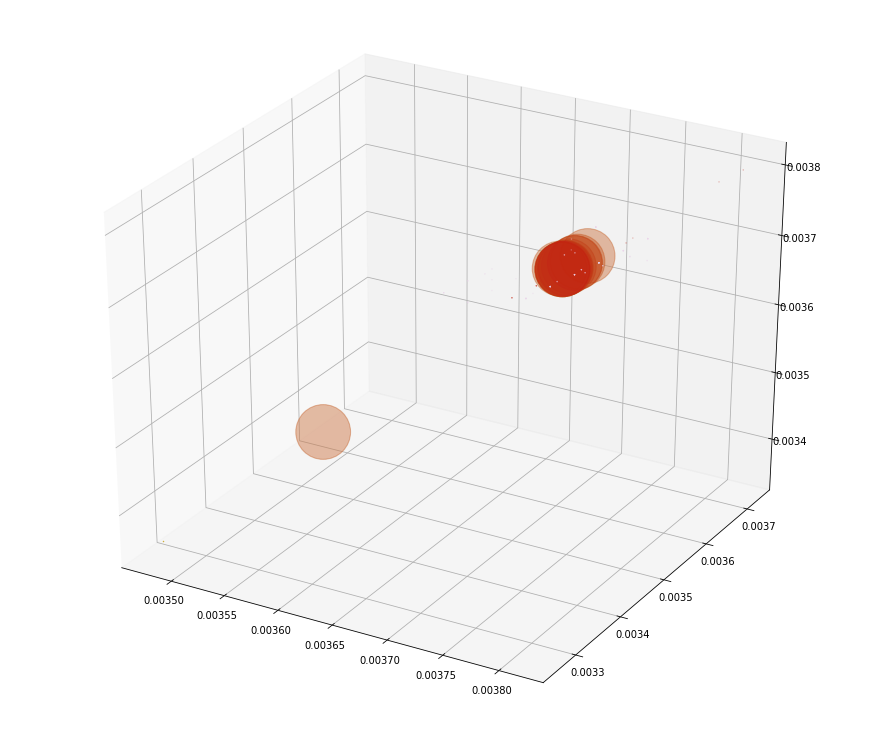

In [289]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)
color = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(listas_pertenencias))]

for i in range(len(listas_pertenencias)):
  if len(listas_pertenencias[i])>0:
    actuales = np.array(listas_pertenencias[i])
    ax.scatter( actuales[:,0], actuales[:,1], actuales[:,2], s=0.18, c=color[i] )
    ax.scatter( mu_final[:,0], mu_final[:,1], mu_final[:,2], s=3000, alpha=0.2, c=color[i] )
plt.show()

## **1.E**

Organice esta nueva matriz como un arreglo de $600\times800\times3$ (es decir, como la imagen original), y grafíquelo. Compare el resultado con la imagen original, e interprete los resultados.

In [ ]:
img_final = np.reshape(nuevas_muestras, (600, 800, 3)) * 256
plt.imshow(img_final)